Implementation of _Weight Uncertainty in Neural Networks_, Charles Blundell et al., May 2015

In [222]:
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

We start with a simple linear regression setting.

In [292]:
N = 250
X = np.random.random(size=(N, 2)) * 3 - 1
X[:, 1] = 1
eps = np.random.normal(scale=0.5, size=(N, 1))
y = (3 * X - 2 + eps)[:, 0]

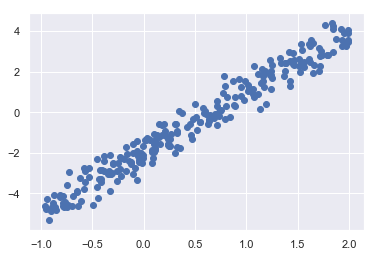

In [293]:
plt.scatter(X[:, 0], y)

This is the exact solution:

In [294]:
w_exact = np.linalg.inv(X.T.dot(X) + 0.1 * np.eye(X.shape[1])).dot(X.T).dot(y)
w_exact

array([ 2.93055722, -1.92501262])

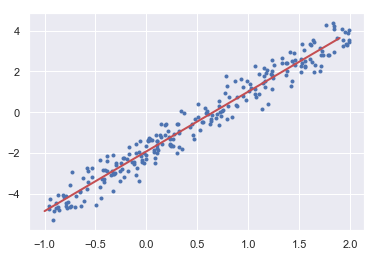

In [393]:
xt = np.arange(-1, 2, 0.1)
yt = xt * w_exact[0] + w_exact[1]

plt.plot(X[:, 0], y, '.')
plt.plot(xt, yt, 'r', linewidth=2)

We now apply the variational method proposed in the paper, where we use Gaussians everywhere (prior, approximate posterior, and likelihood).

In [289]:
class GradientDescentOptimizer:
    def __init__(self, momentum=0.9, base_lrate=1, clip_gradient=1,
                 min_improvement=1e-3, max_steps=1000, verbose=0,
                 raise_exceptions=False):
        self.momentum = momentum
        self.base_lrate = base_lrate
        self.clip_gradient = clip_gradient
        self.min_improvement = min_improvement
        self.max_steps = max_steps
        self.verbose = verbose
        self.raise_exceptions = raise_exceptions

    def log(self, level, *message):
        if level <= self.verbose:
            print(*message)

    def maximize(self, initial, f, *f_args):
        old_gradient = None
        old_value = -np.inf
        parameters = initial
        base_lrate = self.base_lrate
        best = old_value, parameters
        
        for i in range(self.max_steps):
            try:
                value, gradient = f(parameters, *f_args)
            except Exception as exc:
                if self.raise_exceptions:
                    raise
                else:
                    self.log(0, exc)
                    break

            # update best guess
            if value > best[0]:
                best = value, parameters

            # halve learning rate if function decreased
            if value < old_value:
                base_lrate *= 0.5

            # decay learning rate
            lrate = base_lrate / np.sqrt(i + 1)

            # clip gradient
            mag = np.sqrt(np.sum(gradient**2))
            if self.clip_gradient > 0 and mag > self.clip_gradient:
                gradient = gradient * self.clip_gradient / mag

            # apply momentum
            if old_gradient is not None:
                gradient = self.momentum * old_gradient + (1 - self.momentum) * gradient

            # update, log and check for stopping criterion
            parameters += lrate * gradient

            self.log(2, 'IT: %6d | LLI: %14.3f | IM: %14.3e | LR: %14.3e | MAG: %14.3f - %s' % (
                i, value, old_value - value, lrate, mag, parameters
            ))

            if i > 10 and abs(value - old_value) < self.min_improvement:
                break

            old_value, old_gradient = value, gradient

        return best

    def maximize_with_restarts(self, num_restarts, sample_initial, f, *f_args):
        best = None
        for i in range(num_restarts):
            parameters = sample_initial()
            value, parameters = self.maximize(parameters, f, *f_args)
            if best is None or value > best[0]:
                best = value, parameters
            self.log(1, '--------------------- %d - Got: %.4f - Best: %.4f' % (i + 1, value, best[0]))
            self.log(1, '----', parameters)

        return best

In [287]:
def compute_loss(mu, rho, eps, X, y, regu, sigma_noise):
    ''' computes the loss of the model y=Xw, with w computed from mu and rho
        where the approximate posterior, prior, and likelihood are all Gaussian
        returns loss, w, derivatives wrt w, mu and rho
    '''
    
    sigma = np.log(1 + np.exp(rho))
    w = mu + sigma * eps
    
    log_q = -0.5 * np.log(2 * np.pi) - np.log(sigma) - (w - mu)**2 / (2 * sigma**2)
    log_p = -0.5 * np.log(2 * np.pi) - np.log(regu) - w**2 / (2 * regu**2)

    preds = X.dot(w)
    log_d = -0.5 * np.log(2 * np.pi) - np.log(sigma_noise) - (preds - y)**2 / (2 * sigma_noise**2)

    loss = np.sum(log_q) - np.sum(log_p) - np.sum(log_d)

    # compute gradient of loss wrt w
    dlogq_dw = -(w - mu) / sigma**2
    dlogp_dw = -w / regu**2
    dlogd_dw = np.sum(
        -X.T * (preds - y).T / sigma_noise**2,
        axis=1
    )
    dloss_dw = dlogq_dw - dlogp_dw - dlogd_dw

    # compute gradient of loss wrt mu
    dlogq_dmu = np.zeros(mu.shape)
    dlogp_dmu = dlogp_dw
    dlogd_dmu = dlogd_dw
    dloss_dmu = dlogq_dmu - dlogp_dmu - dlogd_dw
    
    # compute gradient of loss wrt rho
    dsigma_drho = np.exp(rho) / (1 + np.exp(rho))
    dw_dsigma = eps
    
    dlogq_drho = -dsigma_drho / sigma
    dlogp_drho = dlogp_dw * dw_dsigma * dsigma_drho
    dlogd_drho = dlogd_dw * dw_dsigma * dsigma_drho
    dloss_drho = dlogq_drho - dlogp_drho - dlogd_drho
    
    return loss, w, dloss_dw, dloss_dmu, dloss_drho

Use gradient checking to make sure everything is computed correctly

In [313]:
mu = np.array([-0.01, 0.5])
rho = np.array([0.2, 0.1])
eps = np.array([-2, 3])
regu = 0.1
sigma_noise = np.sqrt(0.5)


def gradient_check(f, x0, eps=1e-9):
    loss, gradient = f(x0)
    
    for i in range(x0.shape[0]):
        noise = np.zeros(shape=x0.shape)
        noise[i] = eps
        
        loss_neg, _ = f(x0 - noise)
        loss_pos, _ = f(x0 + noise)
        fdiff = (loss_pos - loss_neg) / (2 * eps)
        
        print('Analytical Gradient: %.4f - Finite Differences Gradient: %.4f' %(
            gradient[i], fdiff
        ))
    
        assert np.allclose(gradient[i], fdiff)


print('Checking gradient of mu')
gradient_check(
    lambda x: itemgetter(0, 3)(compute_loss(x, rho, eps, X, y, regu, sigma_noise)),
    x0=mu
)

print('\nChecking gradient of rho')
gradient_check(
    lambda x: itemgetter(0, 4)(compute_loss(mu, x, eps, X, y, regu, sigma_noise)),
    x0=rho
)

Checking gradient of mu
Analytical Gradient: -1157.6573 - Finite Differences Gradient: -1157.6576
Analytical Gradient: 1506.6563 - Finite Differences Gradient: 1506.6562

Checking gradient of rho
Analytical Gradient: 1272.3498 - Finite Differences Gradient: 1272.3508
Analytical Gradient: 2372.1843 - Finite Differences Gradient: 2372.1841


Loss and gradients at the true parameters:

In [321]:
compute_loss(
    np.array([3, -2]), np.array([0, 0]), [0, 0], X, y, 0.1, 0.5
)

(834.7418311082615,
 array([ 3., -2.]),
 array([ 327.55018825, -240.66110113]),
 array([ 327.55018825, -240.66110113]),
 array([-0.72134752, -0.72134752]))

Sample random parameters, plot loss and find minimum

In [369]:
values = []
for i in range(1000):
    params = 20 * (np.random.random(size=2) - 0.5)
    ll, *_ = compute_loss(
        params, np.array([0, 0]), [0, 0], X, y, 0.1, 0.5
    )
    ll = np.log(ll)
    values.append((params, ll))


aa = np.array([(x, y, z) for (x, y), z in values])
min_w0, min_w1, min_loss = aa[aa[:, 2].argmin()]
print('Minimum loss: %.4f at (%.4f, %.4f)' % (np.exp(min_loss), min_w0, min_w1))

Minimum loss: 696.0133 at (2.4335, -1.5742)


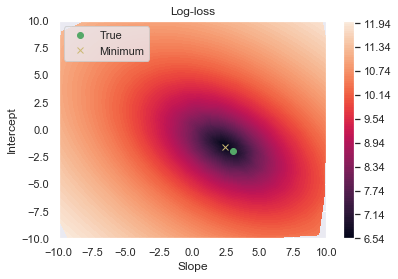

In [381]:
plt.tricontourf(aa[:, 0], aa[:, 1], aa[:, 2], levels=100)
plt.plot(3, -2, 'o', color='g', label='True')
plt.plot(min_w0, min_w1, 'x', color='y', label='Minimum')
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.colorbar()
plt.title('Log-loss')
plt.legend(loc='upper left')
plt.show()

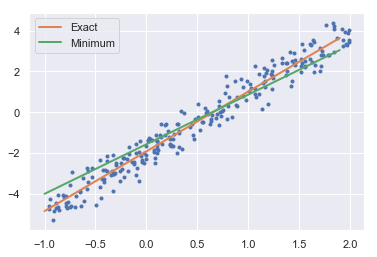

In [394]:
xt = np.arange(-1, 2, 0.1)
plt.plot(X[:, 0], y, '.')
plt.plot(xt, xt * w_exact[0] + w_exact[1], linewidth=2, label='Exact')
plt.plot(xt, xt * min_w0 + min_w1, linewidth=2, label='Minimum')
plt.legend(loc='upper left')
plt.show()

Optimize the parameters using gradient descent:

In [305]:
def target_f(parameters, X, y, regu, sigma_noise):
    param_count = len(parameters) // 2
    mu, rho = parameters[:param_count], parameters[param_count:]
    eps = np.random.normal(size=param_count)
    
    loss, w, dloss_dw, dloss_dmu, dloss_drho = compute_loss(
        mu, rho, eps, X, y, regu, sigma_noise
    )
    
    gradient_mu = dloss_dw + dloss_dmu
    gradient_rho = dloss_dw * eps / (1 + np.exp(-rho)) + dloss_drho
    
    gradient = np.zeros(2 * param_count)
    gradient[:param_count] = gradient_mu
    gradient[param_count:] = gradient_rho
    
    return -loss, -gradient


exact_likelihood, exact_parameters = GradientDescentOptimizer(
    base_lrate=0.1,
    momentum=0.9,
    verbose=2,
    min_improvement=1e-6,
    raise_exceptions=True,
).maximize_with_restarts(
    1,
    lambda: np.random.random(4) - 0.5,
    target_f, X, y, 0.1, np.sqrt(0.5)
)

IT:      0 | LLI:      -2822.155 | IM:           -inf | LR:      1.000e-01 | MAG:       2705.121 - [-0.38753422 -0.23193014 -0.29033564 -0.32385338]
IT:      1 | LLI:      -3816.514 | IM:      9.944e+02 | LR:      3.536e-02 | MAG:       4876.541 - [-0.35987974 -0.2460061  -0.29591264 -0.33675907]
IT:      2 | LLI:      -1616.016 | IM:     -2.200e+03 | LR:      2.887e-02 | MAG:       1913.769 - [-0.33689651 -0.2568354  -0.29900377 -0.34625518]
IT:      3 | LLI:      -2805.919 | IM:      1.190e+03 | LR:      1.250e-02 | MAG:       3088.726 - [-0.32678845 -0.26106224 -0.30069536 -0.34995665]
IT:      4 | LLI:      -2061.120 | IM:     -7.448e+02 | LR:      1.118e-02 | MAG:       2463.898 - [-0.31754711 -0.26430058 -0.30202318 -0.35298053]
IT:      5 | LLI:      -1971.401 | IM:     -8.972e+01 | LR:      1.021e-02 | MAG:       2032.949 - [-0.30912509 -0.26746187 -0.3029361  -0.35573177]
IT:      6 | LLI:      -2553.312 | IM:      5.819e+02 | LR:      4.725e-03 | MAG:       3133.782 - [-0.305